## Hyperparameter search

This stage performs a grid search usign Spark to find the best model for the HLF classifier. We achieve this by training multiple Keras model in parallel.

To run this notebook we used the following configuration:
* *Software stack*: Spark 3.3.2
* *Platform*: CentOS 7, Python 3.9
* *Spark cluster*: Analytix

In [1]:
# No need to run this when using CERN SWAN service
# Just add the configuration parameters for Spark on the "star" button integration

# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-3.3.2-bin-hadoop3') #set path to SPARK_HOME

# Create Spark session and configure according to your environment
from pyspark.sql import SparkSession

spark = ( SparkSession.builder
          .appName("3-Hyperparameter search") \
          .master("yarn")
          .config("spark.driver.memory","4g")
          .config("spark.executor.memory","32g")
          .config("spark.executor.cores","8")
          .config("spark.executor.instances","8")
          .config("spark.dynamicAllocation.enabled", "false")
          .config("spark.sql.execution.arrow.pyspark.enabled", "true")
          .config("spark.ui.showConsoleProgress", "false")
          .getOrCreate()
        )


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/10 16:05:24 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [2]:
# Check if Spark Session has been created correctly
spark

## Load train and test datasets

In [3]:
# Download from https://github.com/cerndb/SparkDLTrigger/tree/master/Data
#
# For CERN users, data is already available on EOS and HDFS
# PATH = "/eos/project/s/sparkdltrigger/public/"
PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled_HLF_features.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled_HLF_features.parquet')\
        .select(['HLF_input', 'encoded_label'])


In [4]:
# Optionally check the number of events in the train and test datasets

test_events = testDF.count()
train_events = trainDF.count()
print('There are {} events in the train dataset'.format(train_events))
print('There are {} events in the test dataset'.format(test_events))

There are 3426083 events in the train dataset
There are 856090 events in the test dataset


### Take small subset of data

In [5]:
# Customize the fraction of data that you want to use
fraction=0.02 # 2%

trainDF_fraction = trainDF.sample(fraction=fraction, seed=42)
testDF_fraction = testDF.sample(fraction=fraction, seed=42)

## Convert training and test datasets from Spark DataFrames to Numpy arrays

Now we will collect and convert the Spark DataFrame into numpy arrays in order to be able to feed them to TensorFlow/Keras. We use the toPandas optimization in Spark to move data faster bewteen JVM and Python.

In [6]:
import numpy as np

trainPDF=trainDF_fraction.toPandas()
testPDF=testDF_fraction.toPandas()

X = np.stack(trainPDF["HLF_input"])
y = np.stack(trainPDF["encoded_label"])

X_test = np.stack(testPDF["HLF_input"])
y_test = np.stack(testPDF["encoded_label"])


In [7]:
trainPDF.head()

,HLF_input,encoded_label
0,"[0.006881238128723883, 0.005688016459164144, 0...","[1.0, 0.0, 0.0]"
1,"[0.00848752162734614, 0.004737287578220116, 0....","[0.0, 0.0, 1.0]"
2,"[0.050887799422459745, 0.02019207179589794, 0....","[0.0, 1.0, 0.0]"
3,"[0.03629554161717421, 0.005379421497281561, 0....","[1.0, 0.0, 0.0]"
4,"[0.0, 0.007202983737923829, 0.0697803274453558...","[0.0, 0.0, 1.0]"


## Create the TF.Keras model

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

## Test baseline model

In [31]:
baseline = create_model(50,20,10)

%time history = baseline.fit(X, y, batch_size=128, epochs=50, validation_data=(X_test, y_test), verbose=0)

CPU times: user 1min 22s, sys: 6.98 s, total: 1min 29s
Wall time: 56.6 s


<IPython.core.display.Javascript object>


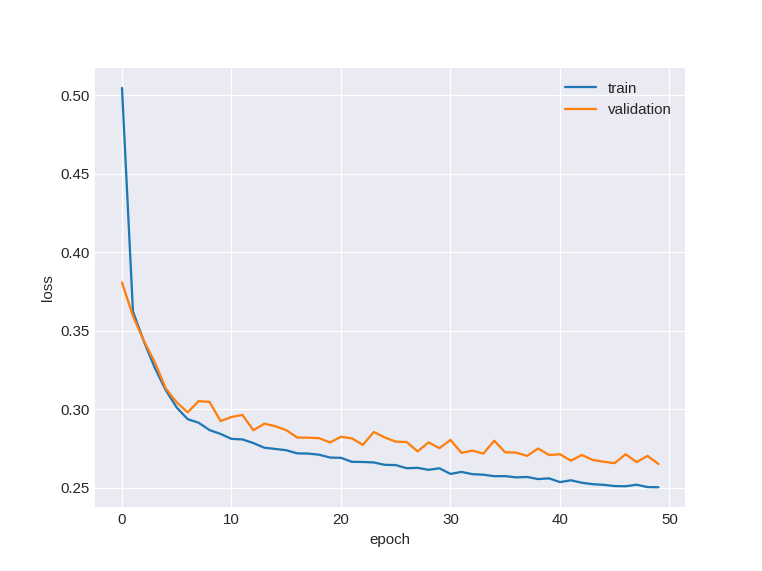

In [29]:
import matplotlib.pyplot as plt 

# Graph with loss vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


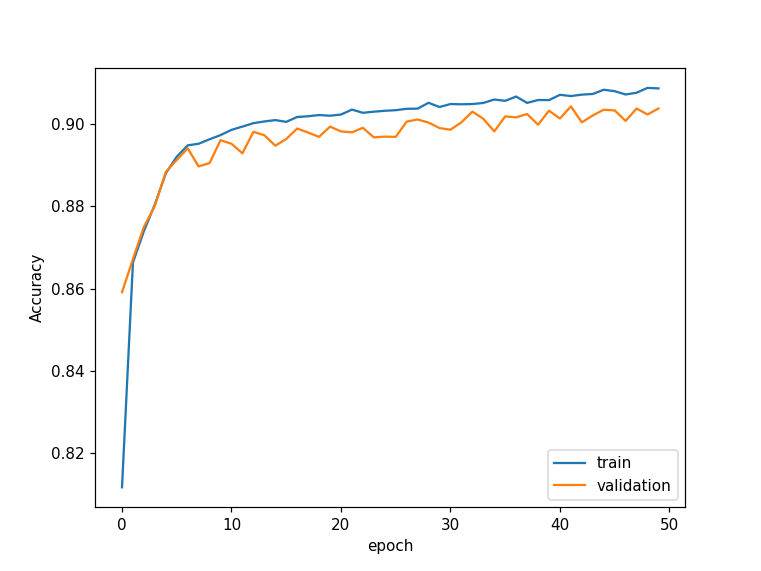

In [11]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

## Confusion Matrix

In [12]:
y_pred=history.model.predict(X_test)
y_true=y_test

541/541 [==============================] - 1s 983us/step


In [13]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9038


/tmp/luca/ipykernel_5076/950292951.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


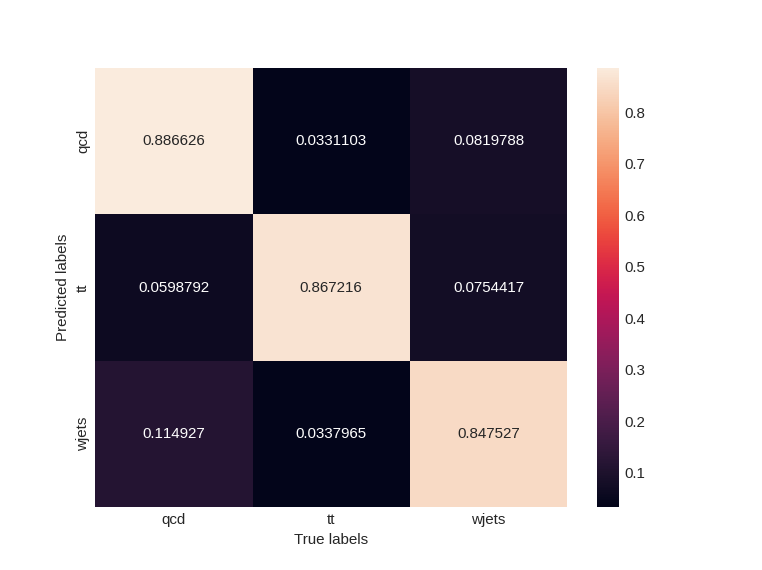

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Create the Keras classifier

Wrapping our keras model into a Sklearn classifier allows us to use Sklearn grid Search. We will the distribute the grid search across executors usign Spark-Sklearn.

In [16]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

/tmp/luca/ipykernel_5076/3505461207.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


## Define the grid parameters

In [20]:
batch_size = [64, 100, 200]
epochs = [10, 30, 50]

## Number of hidden units per layer
nh_1 = [50,100,150]
nh_2 = [20,50,100]
nh_3 = [10,20,50]

In [21]:
param_grid = {'batch_size':batch_size,
              'nb_epoch':epochs,
              'nh_1':nh_1, 'nh_2':nh_2, 'nh_3':nh_3}

## Grid Search with Spark
Spark is used to parallelize grid search.

In [22]:
# This uses joblibspark, originally it was written with spark_sklearn.grid_search now deprecated
# !pip install joblibspark 
from joblibspark import register_spark

register_spark() # register spark backend

In [23]:
from sklearn.utils import parallel_backend
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1)
# Note, for random grid search search use:
# grid = GridSearchCV(sc, estimator=model, param_grid=random_param_grid, cv=5, verbose=1)

with parallel_backend('spark', n_jobs=20):
    %time gridSearch_result = grid.fit(X, y)

23/03/10 16:07:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
CPU times: user 17.9 s, sys: 10.6 s, total: 28.4 s
Wall time: 3min 38s


In [24]:
# Get the parameters giving the best result
gridSearch_result.best_estimator_.get_params()

{'verbose': 0,
 'batch_size': 64,
 'nb_epoch': 50,
 'nh_1': 150,
 'nh_2': 50,
 'nh_3': 50,
 'build_fn': <function __main__.create_model(nh_1, nh_2, nh_3)>}

In [25]:
# See the performance on the test dataset 
y_pred = gridSearch_result.best_estimator_.predict_proba(X_test)

541/541 [==============================] - 1s 1ms/step


In [26]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [27]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9632992611532012, 1: 0.9729295843814089, 2: 0.957723936585449}

<IPython.core.display.Javascript object>


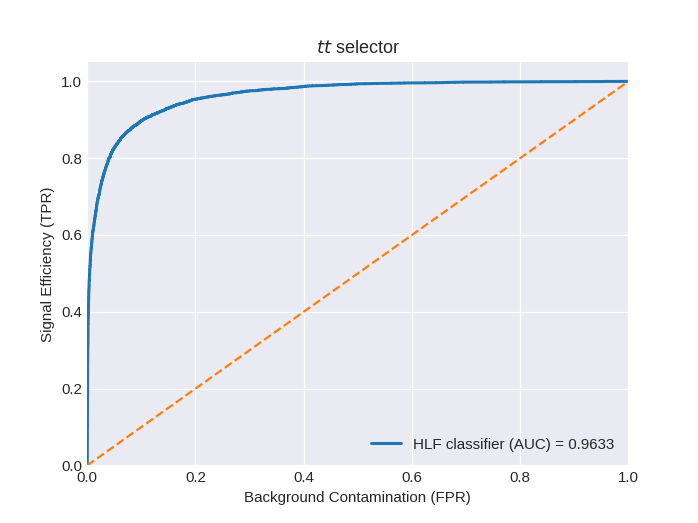

In [28]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()